In [2]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch


from mpl_toolkits.basemap import Basemap
import geopandas
import sys

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [3]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 8  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', 
             '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))',
             'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', 
             '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', 
             '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?
#TODO: test with not all columns!

gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = -1 #set this to -1 if you want all altitudes
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

OVERWRITE = True # be careful!

num_pool_workers = 40 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru

diff_vs = [1,2,3,5,10,20]

available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [4]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Do GITM Plots First

In [5]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

# #OVERRIDE varnames
# plot_start_idx = storm_start_index - 2
# plot_end_idx = storm_start_index + 15

### Read in all gitm files

In [6]:
def read_gitm_into_nparrays(flist):
    """reads a list of gitm filenames and returns a few numpy arrays.
    
    Parameters
    ----------
    flist: list
        List of gitm filenames to read in.
    
    Returns
    -------
    gitmtimes = list
        Datetimes corresponding to the times of the gitm files.
    gitmgrid = dict. 
        Holds the gitm grid for reference. lons/lats have been 
        changed to degrees from rads. Ghost cells removed.
        Keys are ['longitude', 'latitude', 'altitude']
        Index with gitmgrid[time][key][lon][lat][alt]
    gitmvars = list
        The gitm variables.
    gitmbins = numpy array. 
        All of the gitm data (except grid)
        index with gitmbins[time,varnumber,lat,lon,alt]
    
    """

    f = read_routines.read_gitm_file(flist[0])
    gitmgrid = {f['vars'][k].lower() : f[k][2:-2,2:-2,2:-2] for k in [0,1,2]}
    nlons, nlats, nalts = np.array(f[0].shape) - 4 # ghost cells
    gitmvars = [i for i in f['vars'][3:] if i in gitm_cols]

    gitmtimes = []
    gitmbins = np.zeros([len(flist), len(f['vars'])-3, nlons, nlats, nalts])
    
    for ifile, file_name in enumerate(tqdm(flist)):
        f = read_routines.read_gitm_file(file_name)
        
        gitmtimes.append(f['time']) # times
        
        for var in gitm_cols:
            num_v = f['vars'].index(var)
            gitmbins[ifile, num_v-3] = f[num_v][2:-2,2:-2,2:-2] # -3 is to adjust for grid, 2's are for ghost cells
            
    gitmgrid['latitude'] = np.rad2deg(gitmgrid['latitude'])
    gitmgrid['longitude'] = np.rad2deg(gitmgrid['longitude'])
    
    # set and then change the ordering of the longitudes. we want -180->180, not 0->360:
    newlons = []
    for oldlon in gitmgrid['longitude'][:,0,0]:
        if oldlon <=180:
            newlons.append(int(oldlon))
        else:
            newlons.append(int(oldlon)-360)

    new_lons_sorted = np.sort(newlons)
    new_order = np.array([newlons.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

    gitmbins = gitmbins[:,:,new_order,:,:]
    gitmgrid['longitude'] = gitmgrid['longitude'][:,new_order,:]
    
    if global_lat_lim:
        idx_limit = np.argmin(gitmgrid['latitude'] - global_lat_lim)
        gitmbins = gitmbins[:,:,-idx_limit:idx_limit,:,:]
        gitmgrid['latitude'] = gitmgrid['latitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['longitude']= gitmgrid['longitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['altitude']= gitmgrid['altitude'][:,-idx_limit:idx_limit,:,:]
        
    return gitmtimes, gitmgrid, gitmvars, gitmbins

In [7]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def make_fits(gitm_bins):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]

    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()

    filtered_arr = signal.sosfiltfilt(sos, gitm_bins, axis=0)
    return filtered_arr

In [8]:
times, gitm_grid, gitm_vars, gitm_bins = read_gitm_into_nparrays(gitm_files[plot_start_idx:plot_end_idx])

  0%|          | 0/144 [00:00<?, ?it/s]

In [9]:
print('Calculating fits. This will take a moment...')
fits_gitm = make_fits(gitm_bins)


Calculating fits. This will take a moment...


In [16]:
diffs_gitm = (gitm_bins - fits_gitm)/gitm_bins

In [17]:
lats, lons, alts  = np.unique(gitm_grid['latitude']), np.unique(gitm_grid['longitude']), np.unique(gitm_grid['altitude'])

In [20]:
# time = 5
lat = 70
alt = 36


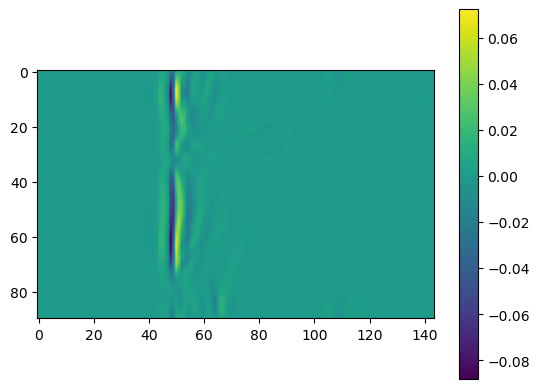

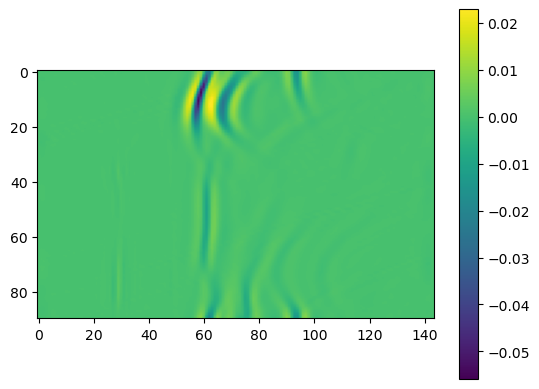

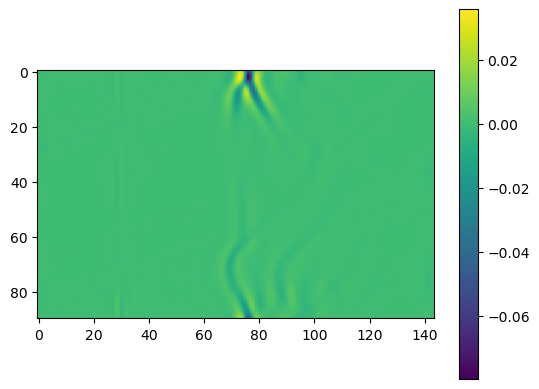

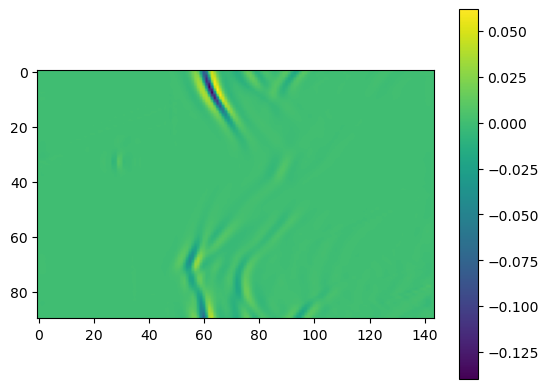

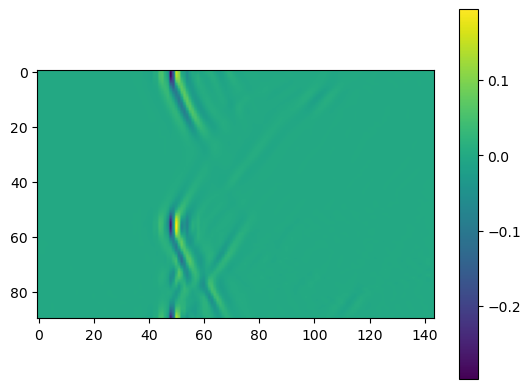

In [22]:

for real_lat in [60, 30, 0, -30, -60]:
    ilat = np.argmin(np.abs(lats - real_lat))
    plt.imshow(diffs_gitm[:,0,:,ilat,alt].T)
    plt.colorbar()
    plt.show()

In [ ]:
len(lats), len(lons), len(alts), gitm_bins.shape

(180, 90, 50, (144, 37, 90, 180, 50))

In [23]:
lons, alts, len(times)

(array([  2.,   6.,  10.,  14.,  18.,  22.,  26.,  30.,  34.,  38.,  42.,
         46.,  50.,  54.,  58.,  62.,  66.,  70.,  74.,  78.,  82.,  86.,
         90.,  94.,  98., 102., 106., 110., 114., 118., 122., 126., 130.,
        134., 138., 142., 146., 150., 154., 158., 162., 166., 170., 174.,
        178., 182., 186., 190., 194., 198., 202., 206., 210., 214., 218.,
        222., 226., 230., 234., 238., 242., 246., 250., 254., 258., 262.,
        266., 270., 274., 278., 282., 286., 290., 294., 298., 302., 306.,
        310., 314., 318., 322., 326., 330., 334., 338., 342., 346., 350.,
        354., 358.]),
 array([100000.        , 101746.2160744 , 103532.76520399, 105373.36296577,
        107285.46399898, 109292.43641211, 111427.40491589, 113740.13702932,
        116302.60251795, 119216.91973438, 122623.96082423, 126668.74629578,
        131398.59548638, 136877.51637131, 143167.01191005, 150316.82916815,
        158361.93047869, 167320.67462182, 177194.89400606, 187970.95735041,
      

# Gitm Alt plots. 

similar to SAMI field line

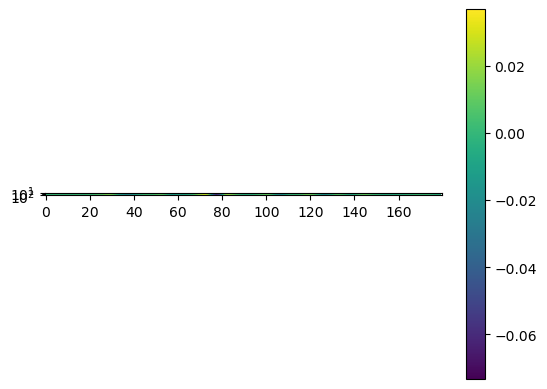

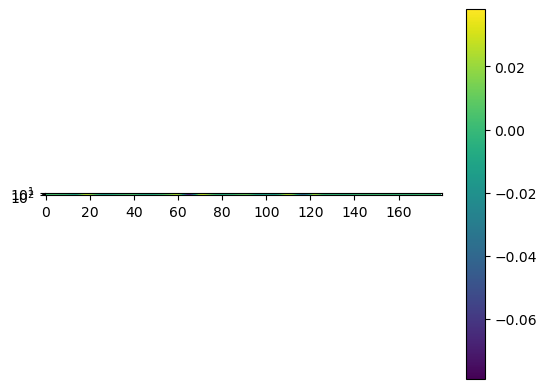

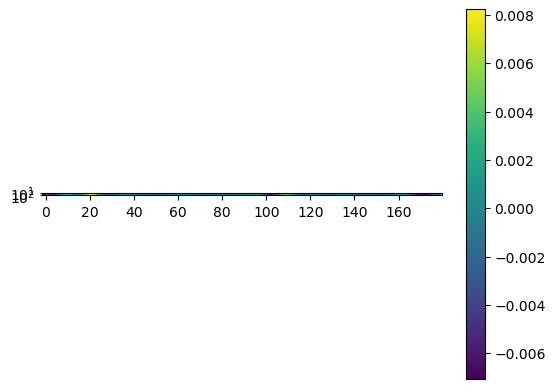

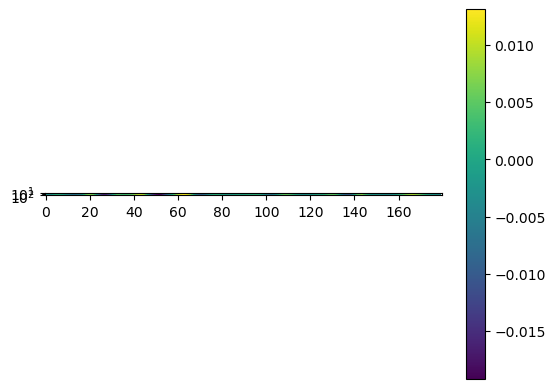

In [29]:
itime = 69
for real_lon in [2,60,180,240]:
    ilon = np.argmin(np.abs(lons - real_lon))
    plt.imshow(diffs_gitm[itime,0,ilon,:,:].T)
    plt.colorbar()
    plt.yscale('log')
    plt.show()